# Dilution time to equilibrium

This notebook performs analyses described in the 

**Manuscript:**

Modelling the decamerisation cycle of PRDX1 and the inhibition-like effect on its peroxidase activity

**Authors:**

C. Barry, C. Pillay, J. Rohwer

**Purpose:**

Performs simulations of dilutions of Prx solutions

Plot: Figure 8a, 8b, S7

**Requirements:**

Python libraries (see **Imports** below)

Prx parameters (filename: `fitted_koff_kon_PRDX1_params.csv`)

Prx dimer-decamer dilution model (`Prx_dim-dec_dil.psc`)

##### Imports

In [1]:
import os
import csv
import math
import copy

import scipy as sp
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import pysces


Matplotlib backend set to: "nbAgg"
Matplotlib interface loaded (pysces.plt.m)
Pitcon routines available
NLEQ2 routines available
SBML support available
You are using NumPy (1.23.5) with SciPy (1.9.3)
Assimulo CVode available
RateChar is available
Parallel scanner is available

PySCeS environment
******************
pysces.model_dir = /home/chris/Pysces/psc
pysces.output_dir = /home/chris/Pysces


***********************************************************************
* Welcome to PySCeS (1.0.3) - Python Simulator for Cellular Systems   *
*                http://pysces.sourceforge.net                        *
* Copyright(C) B.G. Olivier, J.M. Rohwer, J.-H.S. Hofmeyr, 2004-2022  *
* Triple-J Group for Molecular Cell Physiology                        *
* Stellenbosch University, ZA and VU University Amsterdam, NL         *
* PySCeS is distributed under the PySCeS (BSD style) licence, see     *
* LICENCE.txt (supplied with this release) for details                *
* Please cite PySCeS with

###### Get directory paths

In [2]:
prev_dir = os.path.split(os.getcwd())[0]

mod_dir = os.path.join(prev_dir,"models")
if not os.path.isdir(mod_dir): os.mkdir(mod_dir) # ensure dir exists

par_dir = os.path.join(prev_dir,"params")
if not os.path.isdir(par_dir): os.mkdir(par_dir) # ensure dir exists
    
fig_dir = os.path.join(os.getcwd(),"Figures")
if not os.path.isdir(fig_dir): os.mkdir(fig_dir) # ensure dir exists


###### Matplotlib stuff

In [3]:
%matplotlib inline

mpl_width = 4.5
mpl_height = 3.5
mpl_dpi = 600
mpl_xlabel_fontsize = "large"
mpl_ylabel_fontsize = "large"
mu = "\u03bc"


##### params

In [4]:
decamer_param_file = "fitted_koff_kon_PRDX1_params.csv"
onestep_pardict = pd.read_csv(os.path.join(par_dir,decamer_param_file),
                              index_col=0).squeeze('columns').to_dict()


## dilution assay functions

In [5]:
def do_dilution_assay(mod1,
                    dilution_factor,
                    vary="SH_SH_init",
                    vary_init= False,
                    end_time=0.1,
                    points=1000,
                    y_data_out='SH_SH__SH_SH__SH_SH__SH_SH__SH_SH'):
    
    """
    Performs a simulation of diluting a Prx protein solution. 
    
    Outputs the mol fraction of Prx and time array
    """
    # Copy model
    mod = copy.deepcopy(mod1)
    mod.SetQuiet()
    
    # Set expicit experimental concentration
    if vary_init == False:
        vary_init = getattr(mod,vary)
    setattr(mod,vary,vary_init)
    
    # Calculate steady state and copy values as initial for simulation
    mod.doState()
    for i in range(len(mod.species)):
        setattr(mod, f"{mod.species[i]}_init", mod.state_species[i]*1/dilution_factor)
    
    # Do sim
    mod.sim_end = end_time
    mod.sim_points = points
    mod.Simulate()
    
    # Grab data
    x_data = mod.sim["Time"]
    
    t_Prx_dimers = (mod.sim["SH_SH"] + mod.sim["SH_SH__SH_SH__SH_SH__SH_SH__SH_SH"]*5)
    
    y_data_num_multiplier = len(y_data_out.split("__"))
    y_data_num = mod.sim[y_data_out]*y_data_num_multiplier
        
    y_data_fmol = y_data_num/t_Prx_dimers
    y_data = y_data_num
    
    return x_data, y_data_fmol, y_data


## dilution assays

In [6]:
dilution_range = [1,2,5,10,50,100]


In [7]:
# Load model
mod_Prx_dil = pysces.model("Prx_dim-dec_dil.psc", dir=mod_dir)
mod_Prx_dil.mode_integrator = 'CVODE'
mod_Prx_dil.__dict__.update(onestep_pardict)  # this updates the model in a single step
mod_Prx_dil.k_Prx_asso = mod_Prx_dil.kon
mod_Prx_dil.k_Prx_dec_disasso = mod_Prx_dil.koff
mod_Prx_dil.showModel()

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec_dil.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec_dil.psc
Info: No reagents have been fixed
Info: "dilution_factor" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

Fixed species
<none>
 

Reaction stoichiometry and rate equations
Decamer_disassociation:
	SH_SH__SH_SH__SH_SH__SH_SH__SH_SH = {5.00000}SH_SH
	k_Prx_dec_disasso*SH_SH__SH_SH__SH_SH__SH_SH__SH_SH-k_Prx_asso*pow(((SH_SH)),exponent)

Species initial values
SH_SH__SH_SH__SH_SH__SH_SH__SH_SH_init = 0.0000e+00
SH_SH_init = 0.0000e+00

Parameters
k_Prx_dec_disasso = 1.0231e+02
k_Prx_asso = 9.3006e+01
ex

### 450 μM Prx

In [8]:
# Do sim
dim_init = 450
result_dil_450um_Prx = list(map(lambda dil_factor: do_dilution_assay(mod_Prx_dil, 
                                                                     dil_factor, 
                                                                     vary_init=dim_init), 
                                dilution_range))


/tmp/ipykernel_97308/584855975.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


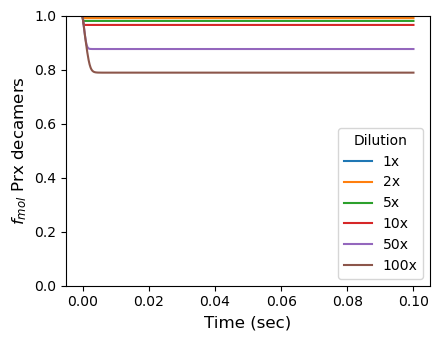

In [9]:
# Plot results
cols = 1
rows = 1

f, axarr = plt.subplots(rows, cols)
f.set_size_inches(w=mpl_width, h=mpl_height)

for count,result in enumerate(result_dil_450um_Prx):
    axarr.plot(result[0],result[1],label=f"{dilution_range[count]}x")

axarr.set_xlabel("Time (sec)", fontsize=mpl_xlabel_fontsize)
axarr.set_ylabel("$f_{mol}$ Prx decamers",fontsize=mpl_ylabel_fontsize)
axarr.set_ylim(0,1)

axarr.legend(title="Dilution",loc="lower right")
f.tight_layout()
f.show()


### 100 μM Prx (figure S7a)

In [10]:
# Do sim
dim_init = 100
result_dil_100um_Prx = list(map(lambda dil_factor: do_dilution_assay(mod_Prx_dil, 
                                                                     dil_factor, 
                                                                     vary_init=dim_init),
                                dilution_range))


/tmp/ipykernel_97308/1742263956.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


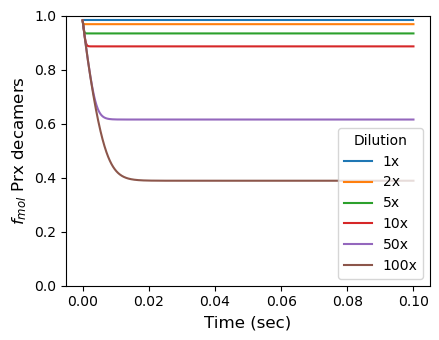

In [11]:
# Plot results
cols = 1
rows = 1

f, axarr = plt.subplots(rows, cols)
f.set_size_inches(w=mpl_width, h=mpl_height)

for count,result in enumerate(result_dil_100um_Prx):
    axarr.plot(result[0],result[1],label=f"{dilution_range[count]}x")

axarr.set_xlabel("Time (sec)", fontsize=mpl_xlabel_fontsize)
axarr.set_ylabel("$f_{mol}$ Prx decamers",fontsize=mpl_ylabel_fontsize)
axarr.set_ylim(0,1)

axarr.legend(title="Dilution",loc="lower right")
f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"dil_fmol_Prx_decamer_vs_time_100um.pdf"),dpi= mpl_dpi)

### 10 μM Prx (figure S7b)

In [12]:
# Do sim
dim_init = 10
result_dil_10um_Prx = list(map(lambda dil_factor: do_dilution_assay(mod_Prx_dil, 
                                                                    dil_factor, 
                                                                    vary_init=dim_init), 
                               dilution_range))


/tmp/ipykernel_97308/845771592.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


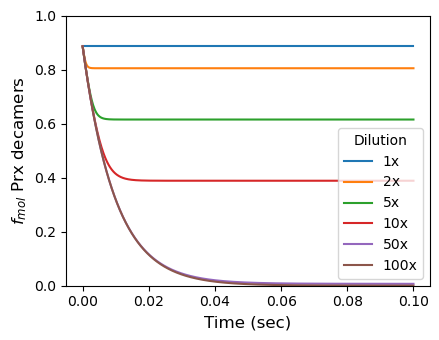

In [13]:
# Plot results
cols = 1
rows = 1

f, axarr = plt.subplots(rows, cols)
f.set_size_inches(w=mpl_width, h=mpl_height)

for count,result in enumerate(result_dil_10um_Prx):
    axarr.plot(result[0],result[1],label=f"{dilution_range[count]}x")

axarr.set_xlabel("Time (sec)", fontsize=mpl_xlabel_fontsize)
axarr.set_ylabel("$f_{mol}$ Prx decamers",fontsize=mpl_ylabel_fontsize)
axarr.set_ylim(0,1)

axarr.legend(title="Dilution")
f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"dil_fmol_Prx_decamer_vs_time_10um.pdf"),dpi= mpl_dpi)

### 1 μM Prx (figure S7c)

In [14]:
# Do sim
dim_init = 1
result_dil_1um_Prx = list(map(lambda dil_factor: do_dilution_assay(mod_Prx_dil, 
                                                                   dil_factor, 
                                                                   vary_init=dim_init), 
                              dilution_range))


/tmp/ipykernel_97308/1067782721.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


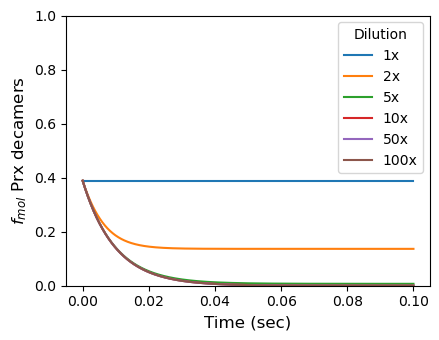

In [15]:
# Plot results
cols = 1
rows = 1

f, axarr = plt.subplots(rows, cols)
f.set_size_inches(w=mpl_width, h=mpl_height)

for count,result in enumerate(result_dil_1um_Prx):
    axarr.plot(result[0],result[1],label=f"{dilution_range[count]}x")

axarr.set_xlabel("Time (sec)", fontsize=mpl_xlabel_fontsize)
axarr.set_ylabel("$f_{mol}$ Prx decamers",fontsize=mpl_ylabel_fontsize)
axarr.set_ylim(0,1)

axarr.legend(title="Dilution")
f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"dil_fmol_Prx_decamer_vs_time_1um.pdf"),dpi= mpl_dpi)

### colated dilution assays (figure 8a, 8b)

Dilution of: 50x


/tmp/ipykernel_97308/2404883738.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


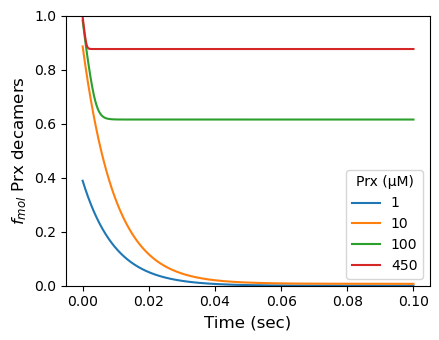

In [16]:
# Plot results
dil_idx = 4

print(f"Dilution of: {dilution_range[dil_idx]}x")

cols = 1
rows = 1

f, axarr = plt.subplots(rows, cols)
f.set_size_inches(w=mpl_width, h=mpl_height)

axarr.plot(result_dil_1um_Prx[dil_idx][0],result_dil_1um_Prx[dil_idx][1],label=f"1")
axarr.plot(result_dil_10um_Prx[dil_idx][0],result_dil_10um_Prx[dil_idx][1],label=f"10")
axarr.plot(result_dil_100um_Prx[dil_idx][0],result_dil_100um_Prx[dil_idx][1],label=f"100")
axarr.plot(result_dil_450um_Prx[dil_idx][0],result_dil_450um_Prx[dil_idx][1],label=f"450")

axarr.set_xlabel("Time (sec)", fontsize=mpl_xlabel_fontsize)
axarr.set_ylabel("$f_{mol}$ Prx decamers",fontsize=mpl_ylabel_fontsize)
axarr.set_ylim(0,1)

axarr.legend(title=f"Prx ({mu}M)")
f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"dil_fmol_Prx_decamer_vs_time_50x.pdf"),dpi= mpl_dpi)

Dilution of: 10x


/tmp/ipykernel_97308/2716308420.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


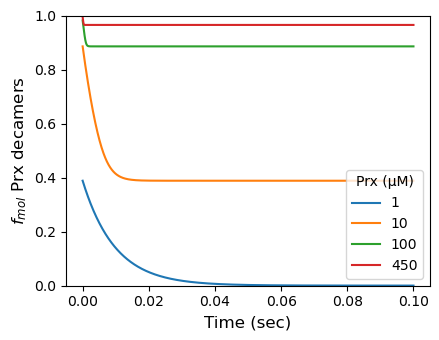

In [17]:
# Plot results
dil_idx = 3

print(f"Dilution of: {dilution_range[dil_idx]}x")

cols = 1
rows = 1

f, axarr = plt.subplots(rows, cols)
f.set_size_inches(w=mpl_width, h=mpl_height)

axarr.plot(result_dil_1um_Prx[dil_idx][0],result_dil_1um_Prx[dil_idx][1],label=f"1")
axarr.plot(result_dil_10um_Prx[dil_idx][0],result_dil_10um_Prx[dil_idx][1],label=f"10")
axarr.plot(result_dil_100um_Prx[dil_idx][0],result_dil_100um_Prx[dil_idx][1],label=f"100")
axarr.plot(result_dil_450um_Prx[dil_idx][0],result_dil_450um_Prx[dil_idx][1],label=f"450")

axarr.set_xlabel("Time (sec)", fontsize=mpl_xlabel_fontsize)
axarr.set_ylabel("$f_{mol}$ Prx decamers",fontsize=mpl_ylabel_fontsize)
axarr.set_ylim(0,1)

axarr.legend(title=f"Prx ({mu}M)")
f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"dil_fmol_Prx_decamer_vs_time_10x.pdf"),dpi= mpl_dpi)